In [42]:
from utils import db
from datetime import date, timedelta, datetime
from decimal import Decimal, ROUND_DOWN
import pandas as pd
from dateutil.relativedelta import relativedelta
from typing import Optional

# Cashflow calculation for July 2023

In [43]:
start_date = date.today()
end_date = date(2023, 8, 7)
WAGE_FRACTION = Decimal(0.4)
BASE_VAT = date(2022, 12, 31)
data = {'Item': [], 'Amount': [], 'Direction': []}
precision = Decimal('0.01')
cashflow_by_date = {}

In [44]:
def add_item(desc: str, amount: Optional[Decimal], direction: str):
    data['Item'].append(desc)
    if amount is None:
        amount = Decimal(0)
    data['Amount'].append(amount.quantize(precision, rounding=ROUND_DOWN))
    data['Direction'].append(direction)
    
def add_cashflow(amount: Decimal, direction: str, the_date: date):
    assert(isinstance(the_date, date))
    cashflow_by_date[the_date] = cashflow_by_date.get(the_date, Decimal(0)) + amount * (1 if direction == 'Credit' else -1)
    

In [45]:
# Create a function that calculates stripe payout date given
# a payment date. The rule is that the payout date is exactly
# three business days after the payment date

def calculate_payout_date(payment_date):
    # Add three days to the payment date
    payout_date = payment_date + timedelta(days=3)
    
    # Check if the payout date is on a weekend
    if payout_date.weekday() == 5: # Saturday
        payout_date += timedelta(days=2)
    elif payout_date.weekday() == 6: # Sunday
        payout_date += timedelta(days=1)
    
    return payout_date

def latest_payment_date(payout_date):
    # Subtract three days from the payout date
    payment_date = payout_date - timedelta(days=3)
    
    # Check if the payment date is on a weekend
    if payment_date.weekday() == 5: # Saturday
        payment_date -= timedelta(days=1)
    elif payment_date.weekday() == 6: # Sunday
        payment_date -= timedelta(days=2)
    
    return payment_date

## Balances

### Current Balances

In [46]:
sql = 'select sum(bt_amount) from tblbanktransaction where bt_acct_no = 1'
barclays_balance = db.safeselect_value(sql)
barclays_balance = Decimal(11715.74) # Override with actual balance
add_item('Barclays Balance', barclays_balance, 'Credit')
add_cashflow(barclays_balance, 'Credit', start_date)

cash_balance = Decimal(3000)
add_item('Cash Balance', cash_balance, 'Credit')
add_cashflow(cash_balance, 'Credit', start_date)

## Upcoming stripe payouts

In [48]:
stripe_in_transit = Decimal(0)
sql = "select sp_arrival_date, sp_amount from tblstripepayout where sp_status = 'in_transit'"
rows = db.safeselect(sql)
if rows:
    for row in rows:
        payout_date = row[0]
        amount = row[1]
        stripe_in_transit += amount
        add_cashflow(amount, 'Credit', payout_date)
add_item('Stripe in transit', stripe_in_transit, 'Credit')


## Stripe balance

In [49]:
sql = 'select sb_amount from vwstripebalance'
stripe_balance = db.safeselect_value(sql)
add_item('Stripe Balance', stripe_balance, 'Credit')
payout_date = calculate_payout_date(start_date)
add_cashflow(stripe_balance, 'Credit', payout_date)

## Expected Bookings

In [50]:
sql = 'select bk_start_date, sum(bk_amt_outstanding) from pa..tblbooking where bk_start_date between ? and ? group by bk_start_date'
# calculate latest payment date
last_date = latest_payment_date(end_date)
outstanding_bookings = Decimal(0)
rows = db.safeselect(sql, start_date, last_date)
if rows:
    for row in rows:
        payment_date = calculate_payout_date(row[0])
        outstanding_bookings += row[1]
        add_cashflow(row[1], 'Credit', payment_date)
add_item('Outstanding Bookings', outstanding_bookings, 'Credit')

## Expenses

### Wages

In [51]:
sql = 'select d_wagepayment, min(date) d_from, max(date) d_to from tbldate where d_wagepayment between ? and ? group by d_wagepayment'
rows = db.safeselect(sql, start_date, end_date)
wage_periods = [(row.d_wagepayment, row.d_from, row.d_to) for row in rows] if rows else []

total_wage = Decimal(0.0)
if wage_periods:
    for (pay_date, from_date, to_date) in wage_periods:
        sql = 'select sum(ts_wages) from vwtimesheet_published where ts_date between ? and ?'
        published_wages = db.safeselect_value(sql, from_date, to_date)

        sql = 'select sum(rv_revenue) from vwrevenue where rv_date between ? and ?'
        revenue = db.safeselect_value(sql, from_date, to_date)
        if not revenue:
            revenue = Decimal(0.0)
        anticipated_wages = WAGE_FRACTION * revenue

        wages = max(published_wages, anticipated_wages)
        total_wage += wages
        add_cashflow(wages, 'Debit', pay_date)
add_item('Total Wage', total_wage, 'Debit')


## Repeat Payments

In [52]:
sql = 'select cfm_desc, cfm_pattern from tblcashflow_monthly where cfm_active = 1 and cfm_frequency = 1'
rows = db.safeselect(sql)
cashflows = [{'description': row.cfm_desc, 'pattern': row.cfm_pattern} for row in rows]

In [53]:
total_monthlys = Decimal(0.0)
sql = 'select bt_bank_date, -bt_amount amount from tblbanktransaction where bt_bank_date between ? and ? and bt_desc like ?'
for cs in cashflows:
    rows = db.safeselect(sql, start_date + timedelta(-35), start_date + timedelta(-1), cs['pattern'])
#    print(f"{cs['description']}: {len(rows)}")
    if not rows:
        continue

    if len(rows) > 1:
        print(f"{cs['description']}: multiple instances")
        continue

    the_date, amount = rows[0].bt_bank_date, rows[0].amount
    next_payment = the_date + timedelta(30)
    if next_payment <= end_date:
        cs['amount'] = amount
        total_monthlys += amount
        add_cashflow(amount, 'Debit', next_payment)
    else:
        print(f"{cs['description']}: next payment {next_payment.strftime('%d/%m')}")
add_item('Monthly items', total_monthlys, 'Debit')

Gsuite: multiple instances
Github: next payment 10/08
ChatGPT: next payment 12/08


## VAT

In [54]:
def vat_payment_date(date):
    new_date = date + relativedelta(months=+2)
    return new_date.replace(day=7)

def vat_payment_amount(start_date: date, end_date: date) -> Decimal:
    sql = 'select sum(be_vat) from tblbankentry where be_date between ? and ?'
    vat_amount = db.safeselect_value(sql, start_date, end_date)
    if not vat_amount:
        vat_amount = Decimal(0.0)
    return vat_amount

vat_dates = []
vat_date = BASE_VAT
while True:
    vat_payment = vat_payment_date(vat_date)
    if vat_payment > end_date:
        break
    vat_start = vat_date + relativedelta(months=-2)
    vat_start = vat_start.replace(day=1)
    if vat_payment >= start_date and vat_payment <= end_date:
        vat_dates.append((vat_start, vat_date, vat_payment))
    vat_date = vat_date + relativedelta(months=+3)

vat_total = Decimal(0.0)

for (vat_start, vat_end, vat_payment) in vat_dates:
    vat_amount = vat_payment_amount(vat_start, vat_end)
    vat_total += vat_amount
    add_cashflow(vat_amount, 'Debit', vat_payment)
    add_item(f'VAT', vat_total, 'Debit')

if vat_dates:
    vat_end = vat_dates[-1][1] + relativedelta(days=+1)
else:
    vat_end = start_date

latest_date = latest_payment_date(end_date)
vat_setaside = vat_payment_amount(vat_end, latest_date) + outstanding_bookings / Decimal(6.0)
add_cashflow(vat_setaside, 'Debit', latest_date)
add_item('VAT Setaside', vat_setaside, 'Debit')

In [55]:
vat_end, end_date, vat_payment_amount(vat_end, end_date)

(datetime.date(2023, 7, 1), datetime.date(2023, 8, 7), Decimal('2106.2587'))

# Summery

In [56]:
df = pd.DataFrame(data)
# Calculate the total 'Amount' where 'Direction' is 'Credit'

total_credit = df.loc[df['Direction'] == 'Credit', 'Amount'].sum()

total_debit = df.loc[df['Direction'] == 'Debit', 'Amount'].sum()

df_credit = df.loc[df['Direction'] == 'Credit']
credit = pd.DataFrame({'Item': ['Total Credit'], 'Amount': [total_credit], 'Direction': ['Credit']})
df_debit = df.loc[df['Direction'] == 'Debit']
debit = pd.DataFrame({'Item': ['Total Debit'], 'Amount': [total_debit], 'Direction': ['Debit']})
net = pd.DataFrame({'Item': ['Net'], 'Amount': [total_credit - total_debit], 'Direction': ['Credit']})

df2 = pd.concat([df_credit, credit, df_debit, debit, net], ignore_index=True)
df2['Amount'] = df2['Amount'].apply(lambda x: '{:,.2f}'.format(x))

df2

Item     Amount Direction
0       Barclays Balance  11,715.73    Credit
1           Cash Balance   3,000.00    Credit
2      Stripe in transit   1,506.13    Credit
3         Stripe Balance     376.69    Credit
4   Outstanding Bookings  14,454.50    Credit
5           Total Credit  31,053.05    Credit
6             Total Wage  14,389.20     Debit
7          Monthly items   3,655.17     Debit
8                    VAT   8,481.54     Debit
9           VAT Setaside   4,515.34     Debit
10           Total Debit  31,041.25     Debit
11                   Net      11.80    Credit

In [57]:
df2.to_excel('cashflow.xlsx', index=False)

# Cash position chart

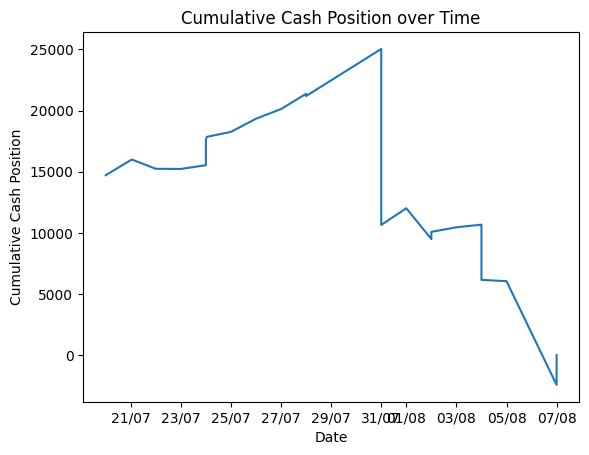

In [58]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(cashflow_by_date.items()), columns=['Date', 'Amount'])

# Convert 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df = df.sort_values('Date')

# Calculate the cumulative sum
df['Cumulative Amount'] = df['Amount'].cumsum()

fig, ax = plt.subplots()

# Plot the cumulative sum
ax.plot(df['Date'], df['Cumulative Amount'])



date_format = mdates.DateFormatter('%d/%m')
ax.xaxis.set_major_formatter(date_format)

plt.xlabel('Date')
plt.ylabel('Cumulative Cash Position')
plt.title('Cumulative Cash Position over Time')
plt.show()


In [59]:
df

Date                          Amount  \
0  2023-07-20 00:00:00   14715.73999999999978172127157   
1  2023-07-21 01:00:00                       1286.0200   
18 2023-07-22 00:00:00                       -759.7900   
19 2023-07-23 00:00:00                        -10.9900   
3  2023-07-24 00:00:00                        301.6900   
4  2023-07-24 00:00:00                       2102.0000   
2  2023-07-24 01:00:00                        220.1100   
5  2023-07-25 00:00:00                        406.0000   
6  2023-07-26 00:00:00                       1076.0000   
7  2023-07-27 00:00:00                        788.0000   
8  2023-07-28 00:00:00                       1250.5000   
20 2023-07-28 00:00:00                       -185.2600   
9  2023-07-31 00:00:00                       3851.5000   
15 2023-07-31 00:00:00  -14389.20000000000079876105730   
10 2023-08-01 00:00:00                       1363.0000   
16 2023-08-02 00:00:00                      -2519.4600   
11 2023-08-02 00:00:00                        593.0000   
12 2023-08-03 00:00:00                        371.0000   
13 2023-08-04 00:00:00                        216.0000   
22 2023-08-04 00:00:00  -4515.342033333333333333333333   
17 2023-08-05 00:00:00                       -104.6700   
21 2023-08-07 00:00:00                      -8481.5415   
14 2023-08-07 00:00:00                       2437.5000   

                 Cumulative Amount  
0    14715.73999999999978172127157  
1    16001.75999999999978172127157  
18   15241.96999999999978172127157  
19   15230.97999999999978172127157  
3    15532.66999999999978172127157  
4    17634.66999999999978172127157  
2    17854.77999999999978172127157  
5    18260.77999999999978172127157  
6    19336.77999999999978172127157  
7    20124.77999999999978172127157  
8    21375.27999999999978172127157  
20   21190.01999999999978172127157  
9    25041.51999999999978172127157  
15   10652.31999999999898296021427  
10   12015.31999999999898296021427  
16    9495.85999999999898296021427  
11   10088.85999999999898296021427  
12   10459.85999999999898296021427  
13   10675.85999999999898296021427  
22   6160.517966666665649626880937  
17   6055.847966666665649626880937  
21  -2425.693533333334350373119063  
14     11.806466666665649626880937